We will use dataset D2 to perform spam/ham classification, using GridSearched SVC.
We shall then see it's performance against DecisionTreeClassifier.

In the end, we will compare the performance of SVC, with few other classifier to evaluate the performance.

In [0]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file
import sklearn.svm.libsvm as libsvm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, log_loss
from random import shuffle

In [8]:
from google.colab import files
import io
uploaded = files.upload()

Saving SMSSpamCollection to SMSSpamCollection (1)


In [5]:
#load the stopwords file from https://algs4.cs.princeton.edu/35applications/stopwords.txt
uploaded = files.upload()
#create the list of the stopwords
f = open("stopwords.txt", "r")
stopwords = f.read()
stopword = stopwords.split('\n')

Saving stopwords.txt to stopwords.txt


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
#method to create transformations
def transform(X):
  #given the matrix as single column with text convert it into vector
  vectorizer = TfidfVectorizer(stop_words=stopword,lowercase=True)
  return vectorizer.fit_transform(X).toarray() 

In [0]:
sms_data =  pd.read_csv(io.BytesIO(uploaded["SMSSpamCollection"]), sep='\t',header = None,index_col=False)
#replace labels spam and ham as 1 or 0
sms_data[0] = sms_data[0].replace(['ham','spam'],[0,1])

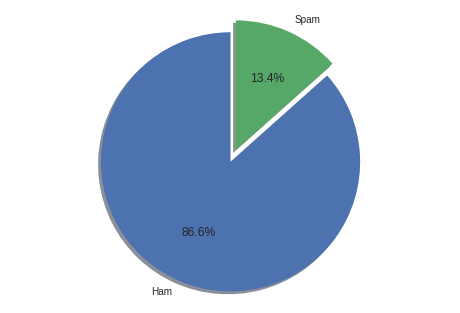

In [17]:
import matplotlib.pyplot as plt
#class distribution of Spam Ham 
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie([(y == 0).sum(),(y == 1).sum()], explode=explode, labels=['Ham','Spam'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Plot a pie chart to describe the data we have 
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
#the usual test and train split
X_train, X_test, y_train, y_test = train_test_split(sms_data[1], sms_data[0], test_size=0.202, random_state=42)

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#Create Pipeline for SVC


svc_c_p = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words = stopword, lowercase = True)),
    ("classifier", SVC())
])

'''
Define the parameter grid to be explored
'''

param_grid = [{"classifier__C" :  [1,25,50,100],
               "classifier__kernel" : ['linear','rbf','sigmoid']}]


svc_grid = GridSearchCV(svc_c_p, cv = 5, n_jobs = 5,
                          param_grid = param_grid[0], verbose = 1, refit = True)

svc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'classifier__C': [1, 25, 50, 100], 'classifier__kernel': ['linear', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [21]:
#let's look at the best estimator
svc_grid.best_estimator_

Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [22]:
#let's look at the best parameter
svc_grid.best_params_

{'classifier__C': 25, 'classifier__kernel': 'linear'}

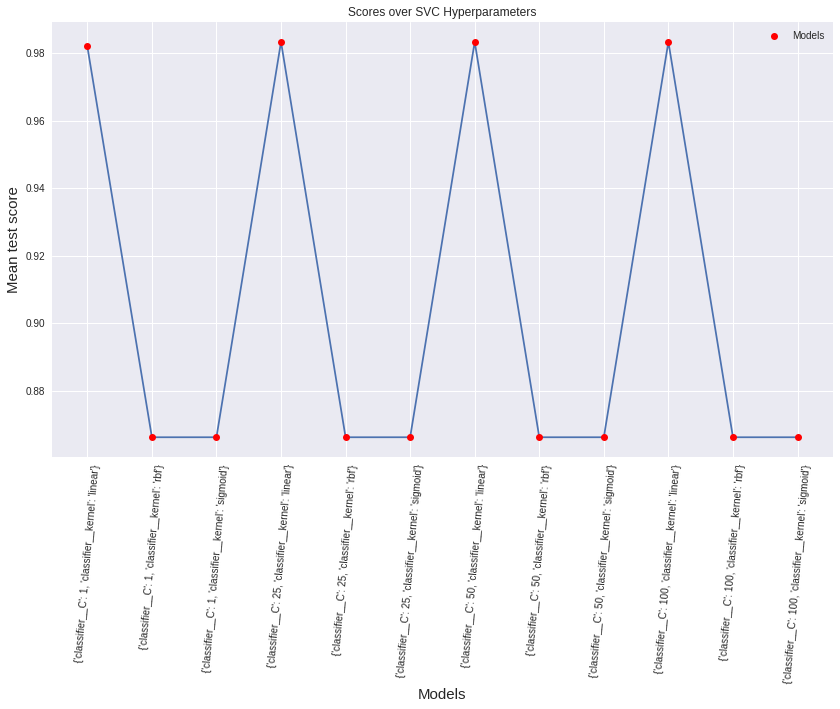

In [25]:
plt.figure(figsize = (14, 8))
plt.title("Scores over SVC Hyperparameters")
plt.plot(svc_grid.cv_results_["mean_test_score"])
plt.plot(svc_grid.cv_results_["mean_test_score"], "ro", label = "Models")


plt.xlabel('Models', fontsize = 15)
plt.ylabel('Mean test score', fontsize = 15)
plt.xticks(range(0, len(svc_grid.cv_results_['params'])), svc_grid.cv_results_['params'], rotation = 85)

plt.legend()
plt.show()

In [28]:
%time pred = svc_grid.predict(X_test)
#%time pred = svc_classifier.predict(X_test)
print('Recall',metrics.recall_score(y_test,pred))
print('Precision',metrics.precision_score(y_test,pred))
print('Accuracy',accuracy_score(y_test,pred)) 
print('Log Loss',log_loss(y_test,pred))

CPU times: user 291 ms, sys: 0 ns, total: 291 ms
Wall time: 294 ms
Recall 0.9671052631578947
Precision 0.9607843137254902
Accuracy 0.9902309058614565
Log Loss 0.3374168187642982


Thus, with our SVC we obtain a precision of 96% and Recall of 96% as well, our log loss is very low as well, with a very high accuracy.

In [30]:
from sklearn import tree
#we will check the performance against the decision tree with best parameters from GridSearch
clf_dt_c_p = Pipeline([
    ("vectorizer", TfidfVectorizer(stop_words = stopword, lowercase = True)),
    ("classifier", tree.DecisionTreeClassifier())
])

'''
Define the parameter grid to be explored
'''

param_grid = [{"classifier__max_depth" :  np.arange(500, 2000, 100)}]


clf_dt_c_p_grid = GridSearchCV(clf_dt_c_p, cv = 5, n_jobs = 5,
                          param_grid = param_grid[0], verbose = 1, refit = True)
clf_dt_c_p_grid.fit(X_train,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.3s
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed:   21.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'classifier__max_depth': array([ 500,  600,  700,  800,  900, 1000, 1100, 1200, 1300, 1400, 1500,
       1600, 1700, 1800, 1900])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [31]:
clf_dt_c_p_grid.best_params_

{'classifier__max_depth': 1300}

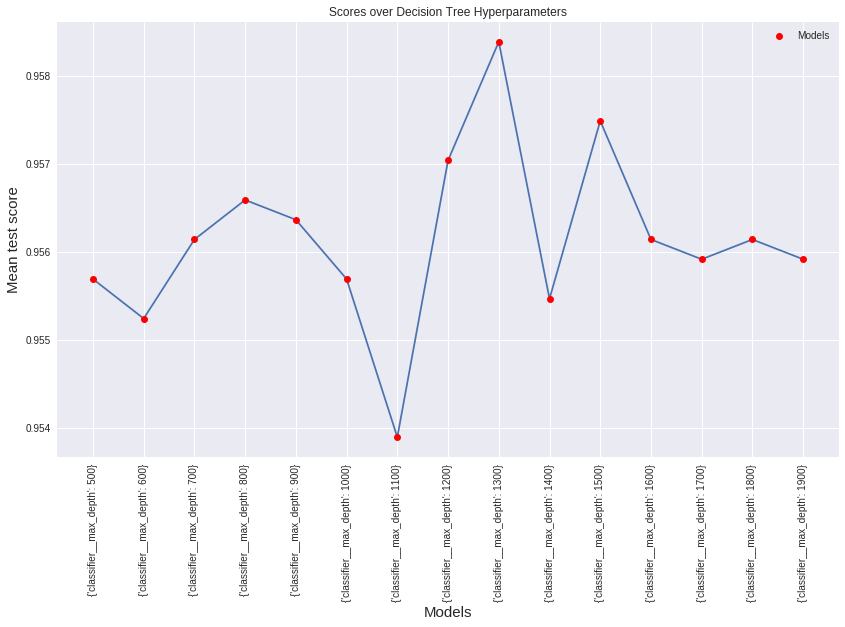

In [52]:
plt.figure(figsize = (14, 8))
plt.title("Scores over Decision Tree Hyperparameters")
plt.plot(clf_dt_c_p_grid.cv_results_["mean_test_score"])
plt.plot(clf_dt_c_p_grid.cv_results_["mean_test_score"], "ro", label = "Models")


plt.xlabel('Models', fontsize = 15)
plt.ylabel('Mean test score', fontsize = 15)
plt.xticks(range(0, len(clf_dt_c_p_grid.cv_results_['params'])), clf_dt_c_p_grid.cv_results_['params'], rotation = 90)

plt.legend()
plt.show()

In [33]:
%time pred = clf_dt_c_p_grid.predict(X_test)
print('Recall',metrics.recall_score(y_test,pred))
print('Precision',metrics.precision_score(y_test,pred))
print('Accuracy',accuracy_score(y_test,pred)) 
print('Log Loss',log_loss(y_test,pred))

CPU times: user 20.2 ms, sys: 1.98 ms, total: 22.2 ms
Wall time: 23.7 ms
Recall 0.8026315789473685
Precision 0.9242424242424242
Accuracy 0.9644760213143873
Log Loss 1.2269618577004708


Thus, with our DecisionTree classifier we obtain a precision of 92%(lower than SVC) and Recall of 80%(lower than SVC) as well, our log loss is very higher than SVC as well.

Thus in comparison with Decision Tree our SVC performs a better classification of Spam and Ham.

In [38]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#we will vectorise the entire data, since we are just benchmarking
y = sms_data[0].as_matrix()
X_text = transform(sms_data[1].as_matrix())
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.202, random_state=42)


#we will try the spam classifier with following list of classifier 

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss","Precsion","Recall"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("=_="*30)
    print(name)
    
    print('****Results****')
    pred = clf.predict(X_test)
    acc = accuracy_score(y_test, pred)
    recall = metrics.recall_score(y_test,pred)
    precison = metrics.precision_score(y_test,pred)
    print("Accuracy: {:.4%}".format(acc))
    print("Recall: {:.4%}".format(recall))
    print("Precision: {:.4%}".format(precison))
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll,recall*100,precison*100]], columns=log_cols)
    log = log.append(log_entry)
    
print("=_="*30)

=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
KNeighborsClassifier
****Results****
Accuracy: 92.7176%
Recall: 46.0526%
Precision: 100.0000%
Log Loss: 1.839040610118253
=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
DecisionTreeClassifier
****Results****
Accuracy: 97.3357%
Recall: 84.8684%
Precision: 94.8529%
Log Loss: 0.9202160673599658


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
RandomForestClassifier
****Results****
Accuracy: 97.0693%
Recall: 78.2895%
Precision: 100.0000%
Log Loss: 0.09706780622170876
=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
AdaBoostClassifier
****Results****
Accuracy: 97.5133%
Recall: 83.5526%
Precision: 97.6923%
Log Loss: 0.6001566496495032
=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
GradientBoostingClassifier
****Results****
Accuracy: 97.2469%
Recall: 81.5789%
Precision: 97.6378%
Log Loss: 0.09608044663984741
=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
GaussianNB
****Results****
Accuracy: 89.6980%
Recall: 90.7895%
Precision: 57.5000%
Log Loss: 3.5581687937918653


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
LinearDiscriminantAnalysis
****Results****
Accuracy: 97.1581%
Recall: 80.2632%
Precision: 98.3871%
Log Loss: 0.9815638051839634


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:516: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 44.8490%
Recall: 98.6842%
Precision: 19.5059%
Log Loss: 19.048472594351274
=_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_==_=


In [39]:
log

,Classifier,Accuracy,Log Loss,Precsion,Recall
0,KNeighborsClassifier,92.717584,1.839041,46.052632,100.000000
0,DecisionTreeClassifier,97.335702,0.920216,84.868421,94.852941
0,RandomForestClassifier,97.069272,0.097068,78.289474,100.000000
0,AdaBoostClassifier,97.513321,0.600157,83.552632,97.692308
0,GradientBoostingClassifier,97.246892,0.096080,81.578947,97.637795
0,GaussianNB,89.698046,3.558169,90.789474,57.500000
0,LinearDiscriminantAnalysis,97.158082,0.981564,80.263158,98.387097
0,QuadraticDiscriminantAnalysis,44.849023,19.048473,98.684211,19.505852


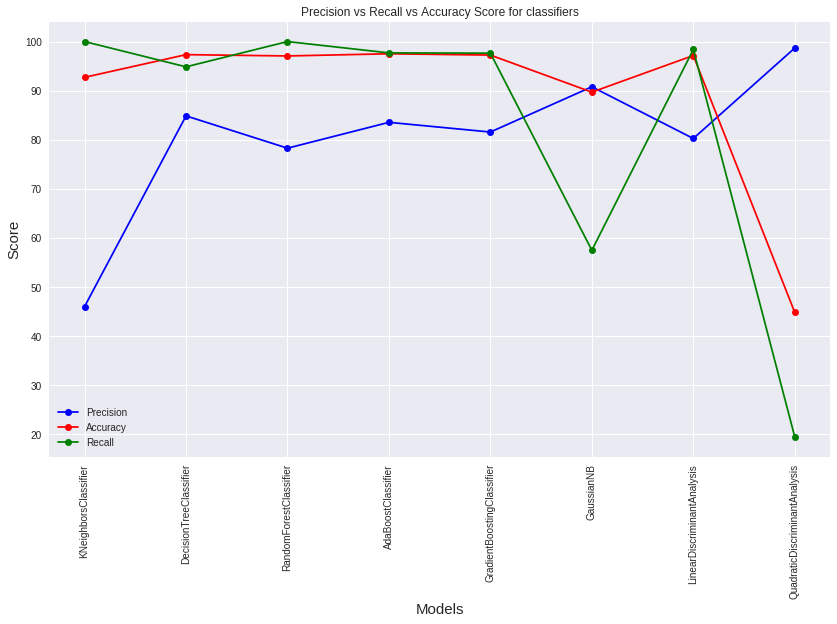

In [50]:
plt.figure(figsize = (14, 8))
plt.title("Precision vs Recall vs Accuracy Score for classifiers")

plt.plot(range(0,8),log["Precsion"], "-bo", label = "Precision")
plt.plot(range(0,8),log["Accuracy"], "-ro", label = "Accuracy")
plt.plot(range(0,8),log["Recall"], "-go", label = "Recall")


plt.xlabel('Models', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.xticks(range(0,8),log['Classifier'], rotation = 90)

plt.legend()
plt.show()

We can observe that QDA has highest Precision while having lowest Accuracy and Recall, which is unacceptable.

GaussianNB on the other can has better Accuracy and Precision but poor recall, which can be accepted.

In case of our SVC we obtained way better accuracy, precision and recall, thus we can say that our SVC model performs better than other 9 classifiers considered here.